In [24]:
import requests
import os
from tqdm import tqdm
import pandas as pd
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud


nltk.download("vader_lexicon")
nltk.download("punkt")


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\Shaun\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Shaun\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [2]:
def download_file(url, filename):
    if os.path.exists(filename):
        print(f"File '{filename}' already exists. Skipping download.")
        return

    try:
        with requests.get(url, stream=True) as r:
            r.raise_for_status()
            total_size_in_bytes = int(r.headers.get("content-length", 0))
            block_size = 16384
            progress_bar = tqdm(total=total_size_in_bytes, unit="iB", unit_scale=True)
            with open(filename, "wb") as file:
                for data in r.iter_content(block_size):
                    progress_bar.update(len(data))
                    file.write(data)
            progress_bar.close()
            if total_size_in_bytes != 0 and progress_bar.n != total_size_in_bytes:
                print("ERROR, something went wrong")
            else:
                print(f"File downloades successfully as {filename}")

    except requests.exceptions.RequestException as e:
        print(f"Error during download: {e}")

file_url = "https://datarepo.eng.ucsd.edu/mcauley_group/data/amazon_2023/raw/review_categories/Appliances.jsonl.gz"
local_filename = "Appliances.jsonl.gz"
download_file(file_url, local_filename)

File 'Appliances.jsonl.gz' already exists. Skipping download.


In [18]:
df = pd.read_json("Appliances.jsonl.gz", compression="gzip", lines=True)

In [ ]:
vader_analyzer = SentimentIntensityAnalyzer()

def get_vader_scores(text):
    scores = vader_analyzer.polarity_scores(text)
    return scores

df['vader_scores'] = df['text'].apply(get_vader_scores)
df['vader_compound'] = df['vader_scores'].apply(lambda x: x['compound'])

In [20]:
def get_vader_sentiment(compound_score):
    if compound_score >= 0.05:
        return 'positive'
    elif compound_score <= -0.05:
        return 'negative'
    else:
        return 'neutral'

df['vader_sentiment'] = df['vader_compound'].apply(get_vader_sentiment)

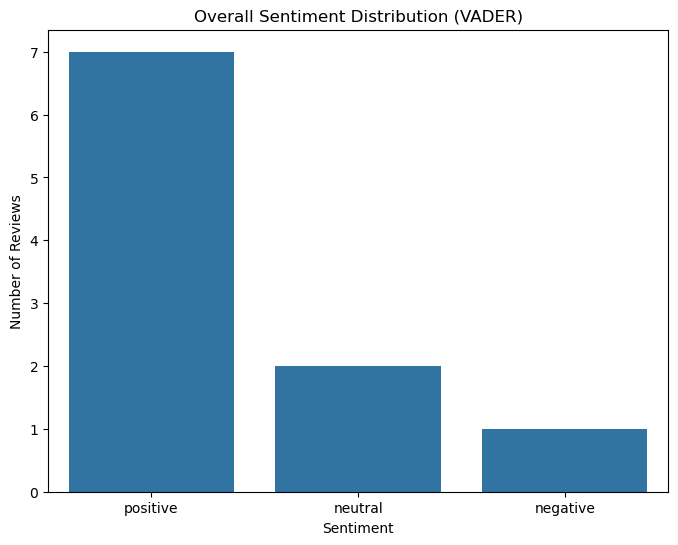

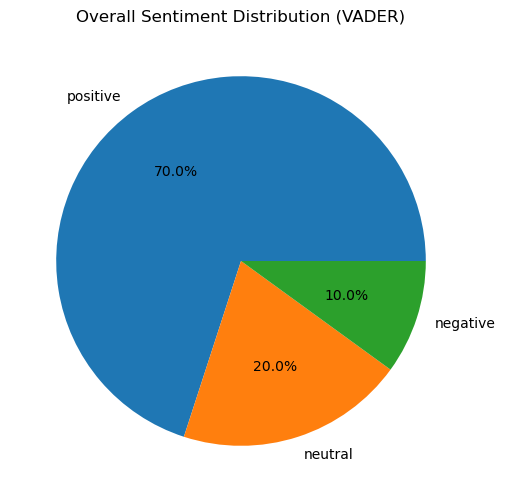

In [ ]:
sentiment_counts = df['vader_sentiment'].value_counts()

plt.figure(figsize=(8, 6))
sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values)
plt.title('Overall Sentiment Distribution (VADER)')
plt.xlabel('Sentiment')
plt.ylabel('Number of Reviews')
plt.show()

plt.figure(figsize=(8, 6))
plt.pie(sentiment_counts.values, labels=sentiment_counts.index, autopct='%1.1f%%')
plt.title('Overall Sentiment Distribution (VADER)')
plt.show()

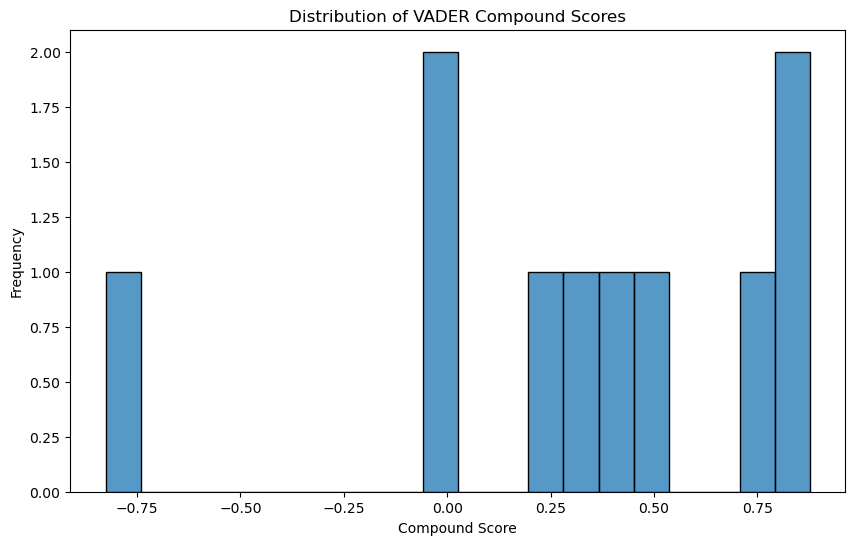

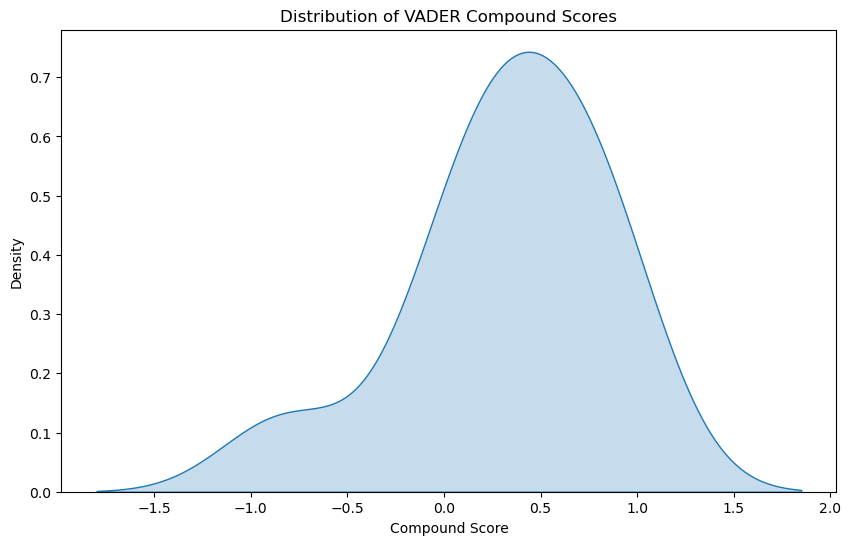

In [30]:
plt.figure(figsize=(10, 6))
sns.histplot(df['vader_compound'], bins=20, kde=False)
plt.title('Distribution of VADER Compound Scores')
plt.xlabel('Compound Score')
plt.ylabel('Frequency')
plt.show()

plt.figure(figsize=(10, 6))
sns.kdeplot(df['vader_compound'], fill=True)
plt.title('Distribution of VADER Compound Scores')
plt.xlabel('Compound Score')
plt.ylabel('Density')
plt.show()

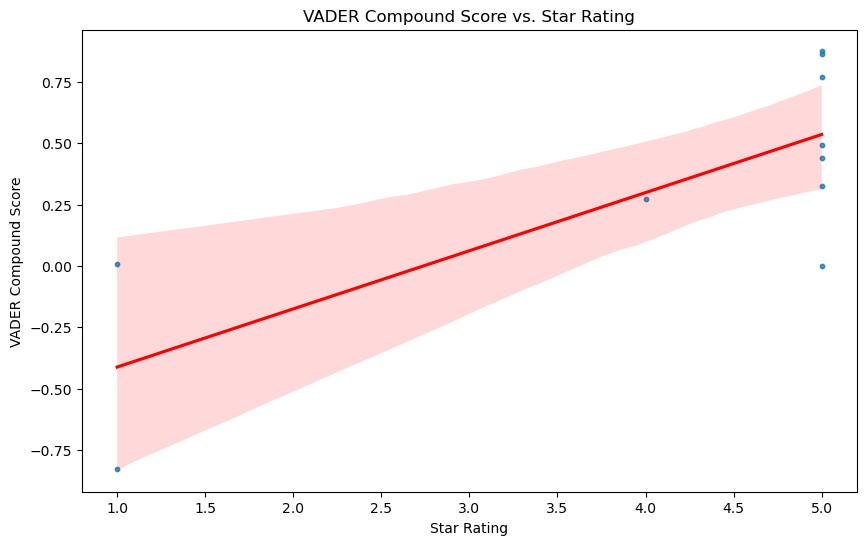

In [31]:
plt.figure(figsize=(10, 6))
sns.regplot(x='rating', y='vader_compound', data=df, scatter_kws={'s': 10}, line_kws={'color': 'red'})
plt.title('VADER Compound Score vs. Star Rating')
plt.xlabel('Star Rating')
plt.ylabel('VADER Compound Score')
plt.show()

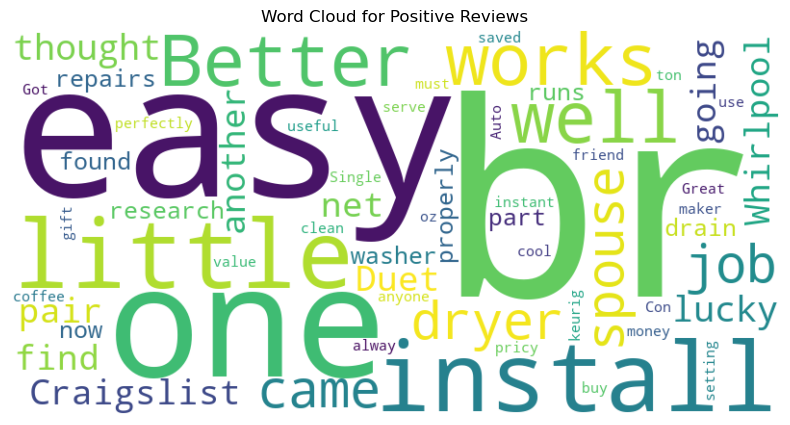

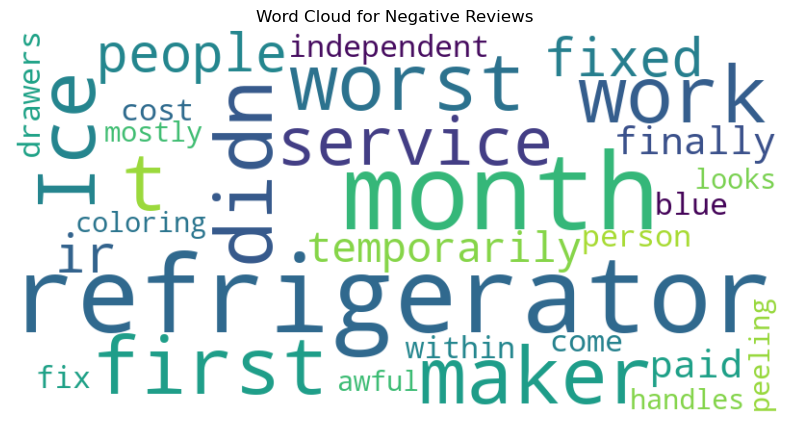

In [32]:
def create_wordcloud(text, title):
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title)
    plt.show()

positive_reviews = df[df['vader_sentiment'] == 'positive']['text'].str.cat(sep=' ')
negative_reviews = df[df['vader_sentiment'] == 'negative']['text'].str.cat(sep=' ')

create_wordcloud(positive_reviews, 'Word Cloud for Positive Reviews')
create_wordcloud(negative_reviews, 'Word Cloud for Negative Reviews')